# 0.6 LDA visualization

This notebook will visualize the LDA model.

In [19]:
import os

import pandas as pd
import engarde.decorators as ed
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import inflect
from joblib import load
import plotly.graph_objs as go
import plotly_express as px
import plotly.io as pio

In [20]:
PROJ_ROOT = os.path.join(os.pardir)
N_TOPICS = 20

In [34]:
def load_data():
    tokenized_read_path = os.path.join(PROJ_ROOT + "/data/processed/" + "tokenized.feather")
    tfidf_read_path = os.path.join(PROJ_ROOT + "/models/" + "tfidf.joblib")
    topic_read_path = os.path.join(PROJ_ROOT + "/models/" + "lda_20" + ".joblib")

    tokenized = pd.read_feather(tokenized_read_path)
    tfidf = load(tfidf_read_path)
    topic_model = load(topic_read_path)


    return tokenized, tfidf, topic_model

In [35]:
tokenized, tfidf, topic_model = load_data()

In [80]:
%%time
pyLDAvis.enable_notebook()

tfidf_vectorizer = CountVectorizer(min_df=5, max_df=0.9)
tfidf = tfidf_vectorizer.fit_transform(tokenized["proc_answers"])

topic_vis_data = pyLDAvis.sklearn.prepare(topic_model, tfidf, tfidf_vectorizer, sort_topics=False)

CPU times: user 59 s, sys: 1.44 s, total: 1min
Wall time: 3min 56s


/Users/dflanaga/miniconda3/envs/data-availability/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [116]:
pyLDAvis.display(topic_vis_data)

In [117]:
topic_vis_data_tsne = pyLDAvis.sklearn.prepare(
    topic_model, tfidf, tfidf_vectorizer, sort_topics=False, mds="tsne"
)

pyLDAvis.display(topic_vis_data_tsne)

/Users/dflanaga/miniconda3/envs/data-availability/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [118]:
topic_vis_data_mmds = pyLDAvis.sklearn.prepare(
    topic_model, tfidf, tfidf_vectorizer, sort_topics=False, mds="mmds"
)

pyLDAvis.display(topic_vis_data_mmds)

/Users/dflanaga/miniconda3/envs/data-availability/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [119]:
# Save the LDA visualizations

models = {"topic_vis_data": topic_vis_data, "topic_vis_data_tsne": topic_vis_data_tsne, "topic_vis_data_mmds":topic_vis_data_mmds}

start_file_number = 1

for key, value in models.items():
    save_path = os.path.join(PROJ_ROOT + "/reports/figures/" + "0.6-0" + str(start_file_number) + "-ldavis_" + key + ".html")
    start_file_number +=1
    pyLDAvis.save_html(value, save_path)

In [102]:
# Name the topics
dict_topic_name = {i: "topic_" + str(i + 1) for i in range(N_TOPICS)}
custom_names = {
    0: "1: Available in repository",
    1: "2: Available in sequence database",
    2: "3: Freely available in data hub",
    3: "4: On request due to privacy/ethics restrictions",
    4: "5: Third party restrictions",
    5: "6: Uncharacterizable",
    6: "7: Mixed",
    7: "8: Available on reasonable request",
    8: "9: Available on reasonable request",
    9: "10: Available but with restrictions (clinical or commercial)",
    10: "11: Article contains a data availability statement",
    11: "12: Data is available",
    12: "13: Included in supporting information",
    13: "14: Available from author by email",
    14: "15: Genetics databases",
    15: "16: Included in supporting information",
    16: "17: Available at URL",
    17: "18: Available at URL",
    18: "19: Available at repository with DOI",
    19: "20: Available upon request"
}
dict_topic_name.update(custom_names)

print(dict_topic_name)

{0: '1: Available in repository', 1: '2: Available in sequence database', 2: '3: Freely available in data hub', 3: '4: On request due to privacy/ethics restrictions', 4: '5: Third party restrictions', 5: '6: Uncharacterizable', 6: '7: Mixed', 7: '8: Available on reasonable request', 8: '9: Available on reasonable request', 9: '10: Available but with restrictions (clinical or commercial)', 10: '11: Article contains a data availability statement', 11: '12: Data is available', 12: '13: Included in supporting information', 13: '14: Available from author by email', 14: '15: Genetics databases', 15: '16: Included in supporting information', 16: '17: Available at URL', 17: '18: Available at URL', 18: '19: Available at repository with DOI', 19: '20: Available upon request'}


In [104]:
# Create the document-topic matrix - show which topic is dominant in each "document"
document_model = pd.DataFrame(topic_model.transform(tfidf))
document_model.columns.name = "topic"
document_model.rename(columns=dict_topic_name, inplace=True)

In [105]:
def top_documents_topics(topic_name, n_doc=3):

    p = inflect.engine()

    document_index = list(
        document_model[topic_name].sort_values(ascending=False).index
    )[:n_doc]

    for order, i in enumerate(document_index):
        print(
            f"Text for the {p.ordinal(order + 1)} most representative document ({i}) for topic {topic_name}:\n"
        )
        print(tokenized.iloc[i, 4])
        print("\n******\n")

In [106]:
top_documents_topics("1: Available in repository", n_doc=20)

Text for the 1st most representative document (103310) for topic 1: Available in repository:

The date that support the findings of this study are openly available in [LUND UNIVERSITY LIBRARIES] at [http://lup.lub.lu.se/student-papers/record/8936336], reference NO. 1 The date that support the findings of this study are openly available in [PLOS One] at https://doi.org/[10.1371/journal.pone.0135231], reference NO. 2 The date that support the findings of this study are openly available in [Progress In Electromagnetics Research] at https://doi.org/[ 10.2528/PIER14101001], reference No. 3 The date that support the findings of this study are openly available in [OSA Publishing] at https://doi.org/[10.1364/AO.48.005668], reference NO. 4 The date that support the findings of this study are openly available in [Wiley Online Library] at https://doi.org/[10.1002/ece3.4054], reference NO. 5 The date that support the findings of this study are openly available in [Wiley Online Library] at https://

In [107]:
# What are the proportions of different topics?

topics_proportion = document_model.sum()/document_model.sum().sum()

topics_proportion = topics_proportion.to_frame().reset_index().rename(columns={0:"percentage"})

topics_proportion.head()

,topic,percentage
0,1: Available in repository,0.033558
1,2: Available in sequence database,0.029767
2,3: Freely available in data hub,0.030857
3,4: On request due to privacy/ethics restrictions,0.041974
4,5: Third party restrictions,0.034411


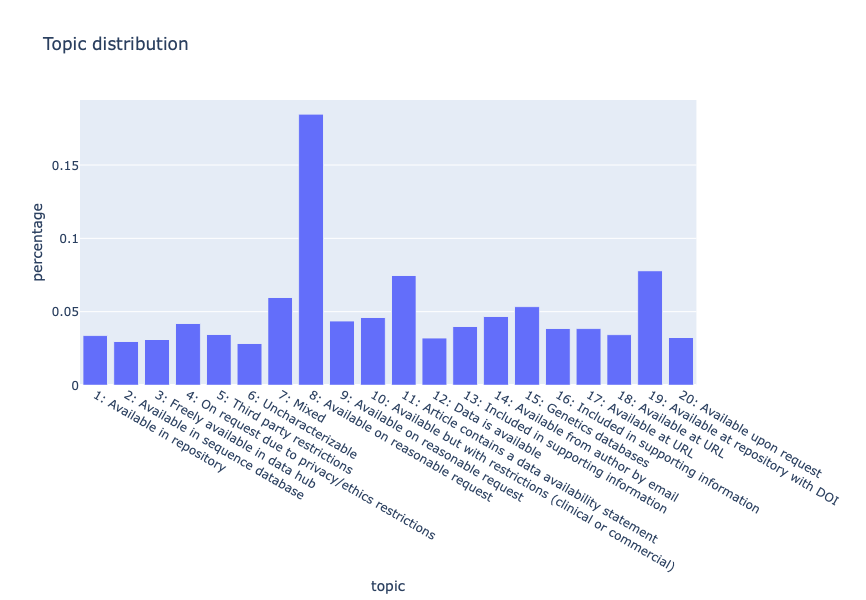

In [113]:
fig = px.bar(topics_proportion, x="topic", y="percentage", title="Topic distribution")

fig_path = os.path.join(PROJ_ROOT + "/reports/figures/" + "0.6-04-topic_percentage")

pio.write_html(fig, fig_path + ".html", include_plotlyjs="cdn")
pio.write_image(fig, fig_path + ".svg")

fig.show()

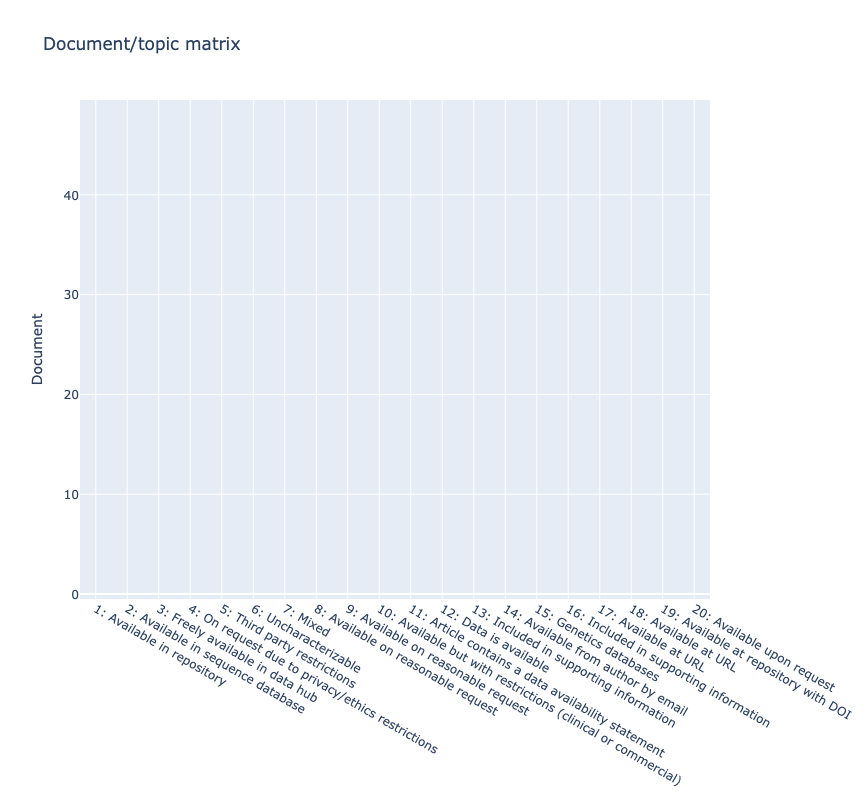

In [114]:
# Show topic matrix for a subset of documents

df = document_model.head(50)

fig = go.Figure(
    data=go.Heatmap(
        z=df.values, x=df.columns, y=df.index, showscale=False
    ),
    layout_title_text="Document/topic matrix",
    layout_yaxis_title_text="Document",
    layout_height=800
)

fig_path = os.path.join(PROJ_ROOT + "/reports/figures/" + "0.6-05-document-topic-matrix")

pio.write_html(fig, fig_path + ".html", include_plotlyjs="cdn")
pio.write_image(fig, fig_path + ".svg")

fig.show()

In [110]:
# show the top x words in each topic

N_TOP_WORDS = 30
feature_names = tfidf_vectorizer.get_feature_names()


def get_top_words_topic(topic_idx):
    topic = topic_model.components_[topic_idx]

    print([feature_names[i] for i in topic.argsort()[: -N_TOP_WORDS - 1 : -1]])


for topic_idx, topic in enumerate(topic_model.components_):
    print("Topic #%d:" % topic_idx)
    get_top_words_topic(topic_idx)
    print("")

Topic #0:
['reference', 'available', 'number', 'study', 'datum', 'finding', 'repository', 'date', 'national', 'center', 'url', 'biotechnology', 'accession', '½figshareâ', 'dataverse', 'doi', 'archive', 'library', 'information', 'embargo', 'â½figshareã', 'publication', 'harvard', 'pubmed', 'institute', 'research', 'chinese', 'academy', 'oxford', 'dbgap']

Topic #1:
['database', 'datum', 'trait', 'available', 'variant', 'plant', 'process', 'genetic', 'university', 'functional', 'global', 'specie', 'id', 'clinvar', 'european', 'mg', 'server', 'try', 'complete', 'image', 'fish', 'submission', 'study', 'non', 'rast', 'sample', 'gene', 'previous', 'accessible', 'csic']

Topic #2:
['datum', 'website', 'experiment', 'cancer', 'data', 'tcga', 'location', 'genome', 'link', 'portal', 'atlas', 'available', 'ms', 'usgs', 'analysis', 'bird', 'release', 'ch', 'university', 'database', 'accessible', 'australia', 'sciencebase', 'following', 'protein', 'tropical', 'simulated', 'intended', 'program', 'em

In [111]:
# Show which words are most important in the topics

word_model = pd.DataFrame(topic_model.components_.T)
word_model.index = feature_names
word_model.columns.name = "topic"

word_model["norm"] = (word_model).apply(lambda x: x.abs().max(), axis=1)

word_model = word_model.sort_values(by="norm", ascending=0)

word_model.rename(columns=dict_topic_name, inplace=True)

del word_model["norm"]

word_model.head()

topic,1: Available in repository,2: Available in sequence database,3: Freely available in data hub,4: On request due to privacy/ethics restrictions,5: Third party restrictions,6: Uncharacterizable,7: Mixed,8: Available on reasonable request,9: Available on reasonable request,10: Available but with restrictions (clinical or commercial),11: Article contains a data availability statement,12: Data is available,13: Included in supporting information,14: Available from author by email,15: Genetics databases,16: Included in supporting information,17: Available at URL,18: Available at URL,19: Available at repository with DOI,20: Available upon request
datum,1567.439801,293.243173,1058.156036,5267.331546,2928.037969,6.455544,6758.784943,25790.350106,528.448470,5276.891549,9012.381909,782.920532,2652.439730,4820.504787,2052.247593,1453.977996,2861.441516,863.015168,6312.835023,1571.096608
available,1911.147285,190.052210,198.184787,4859.935025,1462.027890,44.670324,2604.012352,25739.176476,3170.887604,1196.097069,2189.342263,374.707713,659.676163,3972.608253,1772.085407,309.230207,1325.194713,723.731700,1437.059463,911.173096
study,1731.095962,66.159550,34.797272,488.551239,1659.520951,72.506882,65.300712,25718.135238,2835.267995,1435.924509,4244.549996,157.010418,717.408876,4.873836,551.436009,86.413132,259.506952,37.577492,3.998294,370.964684
finding,1518.656321,0.050000,0.050000,344.880019,723.241688,0.050000,0.050000,25569.491394,0.050000,295.764760,0.050000,40.360221,0.087261,0.061109,0.050000,0.050000,12.605694,0.050000,0.050000,11.351533
author,0.050000,0.050000,0.050000,163.448829,3.976095,0.050000,0.050000,24534.849902,2527.882433,63.146944,0.050000,0.050000,55.927734,3397.117147,0.050000,0.050000,0.050000,0.050000,0.050000,0.050916


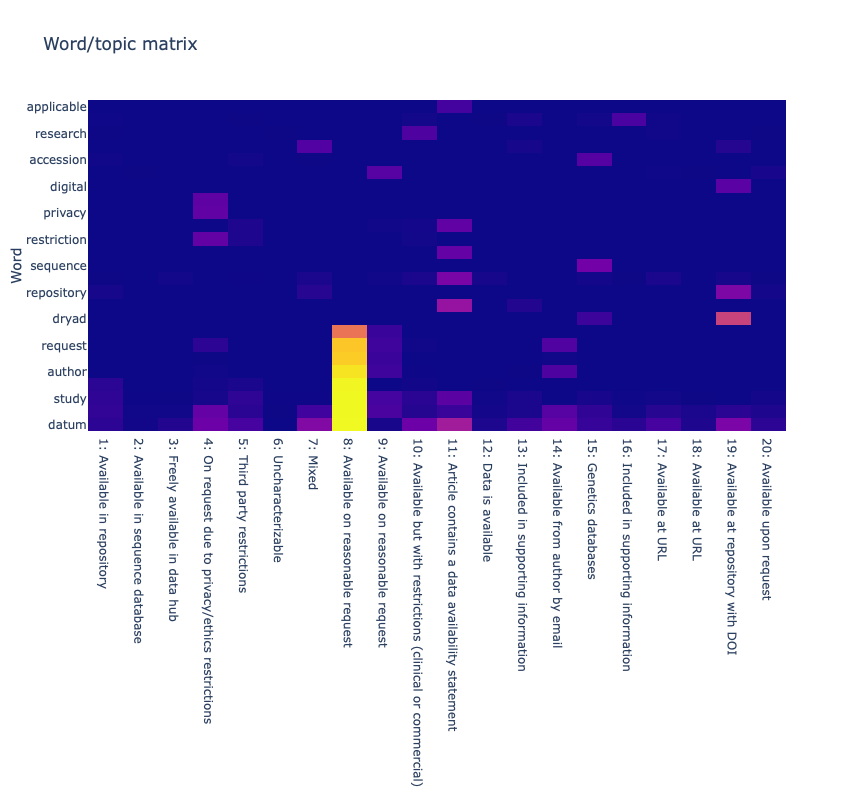

In [120]:
# Show topic matrix for a subset of words

df = word_model.head(25)

fig = go.Figure(
    data=go.Heatmap(
        z=df.values, x=df.columns, y=df.index, showscale=False
    ),
    layout_title_text="Word/topic matrix",
    layout_yaxis_title_text="Word",
    layout_height=800
)

fig_path = os.path.join(PROJ_ROOT + "/reports/figures/" + "0.6-06-word-topic-matrix")

pio.write_html(fig, fig_path + ".html", include_plotlyjs="cdn")
pio.write_image(fig, fig_path + ".svg")

fig.show()